In [1]:
import json
import os
import pandas as pd
# from main import show_arch_comp_results, get_results_from_folder
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from utils.customtypes import Circuit

# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})


plt.style.use('tableau-colorblind10')
palette = {
    "Vibrant Blue": "#3485fd",   # Primary brand color, deep and saturated
    "Sun Yellow": "#ffcb2f",     # Brightest, highest contrast
    "Royal Purple": "#8660cb",   # Deep, rich secondary color
    "Lush Green": "#4ab563",     # Success/Nature
    "Coral Red": "#e25563",      # Error/Warning, slightly softened
    "Ocean Turquoise": "#44d2a8",  # Clear, bright accent
    "Sunset Orange": "#fd933a",   # Warm and vibrant
    "Sky Light Blue": "#3cb1c3"   # Tertiary cool color
}

# Embedding Size Comparison

In [ ]:
data = show_arch_comp_results('../trained/architecture')
data = sorted([(int(k.split('_')[1]),v) for k,v in data.items()])
data = data[1:] # Remove first value as it makes it difficult to see the data
x = [d[0] for d in data]
y = [d[1] for d in data]
print(data)
plt.scatter(x, y, marker="x")
plt.plot(x, y)

plt.xscale('log', base=2)
plt.xticks(x, [str(t) for t in x])

# plt.grid()
plt.xlabel("Embedding size (H), log scale")
plt.ylabel("Normalized cost")


In [ ]:
results = get_results_from_folder('../trained/architecture')
results = sorted([(int(k.split('_')[1]),v) for k,v in results.items()])[1:]

# plt.grid()

for (k,v) in results:
  cost = v['validation_cost']
  plt.plot(list(range(len(cost))), cost, label=k)

plt.legend(loc="best")
plt.xlabel("Train iteration")
plt.ylabel("Normalized cost")

# Depth comparison

In [ ]:
data = show_arch_comp_results('../trained/shape')
data = {k.split('_')[1]:v for k,v in data.items()}

# Extract keys and values
labels = ['direct', 'double', 'triple', 'end']
values = list(data[l] for l in labels)

# Create bar plot
bars = plt.bar(labels, values)
plt.ylim((1.4,1.6))
plt.ylabel("Normalized cost")

# plt.xticks(x, [str(t) for t in x])

In [ ]:
results = get_results_from_folder('../trained/shape')
results = {k.split('_')[1]:v for k,v in results.items()}

# plt.grid()

for l in labels:
  cost = results[l]['validation_cost']
  plt.plot(list(range(len(cost))), cost, label=l)

plt.legend(loc="best")
plt.xlabel("Train iteration")
plt.ylabel("Normalized cost")

# Training DA

Text(0, 0.5, 'Loss')

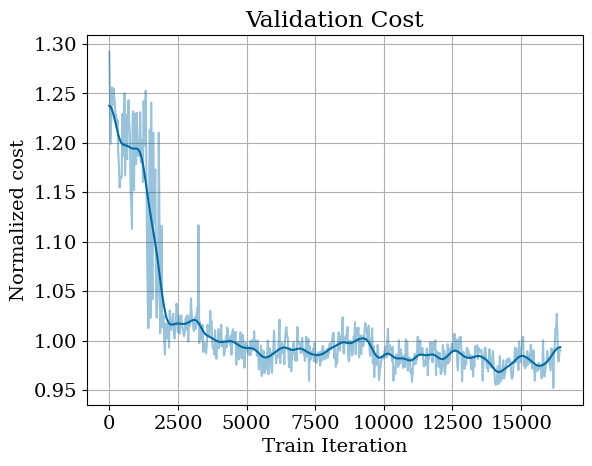

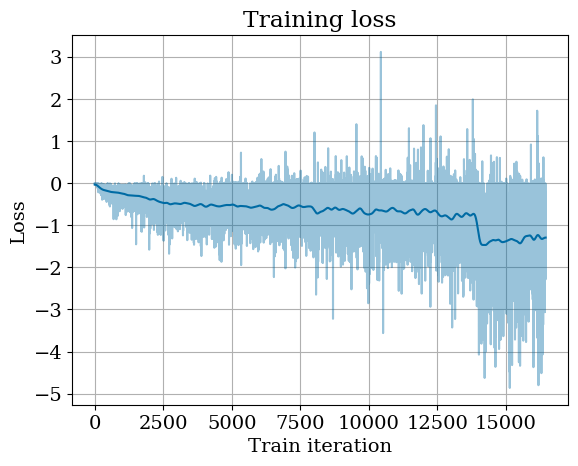

In [2]:
def load_tdata(model: str) -> dict:
    with open(f'../trained/{model}/train_data.json', 'r') as f:
        return json.load(f)

def merge_tdata(data_list: list[dict]) -> dict:
    return {k: sum(map(lambda d: d[k], data_list), [])
            for k in data_list[0].keys() if isinstance(data_list[0][k], list)}

results = merge_tdata([load_tdata('da'), load_tdata('da_ft'), load_tdata('da_ft_v2')])
# results = load_tdata('da_ft')

gaussian_sigma = 7.0

plt.figure()
plt.plot(list(i*25 for i in range(len(results['val_cost']))), results['val_cost'], alpha=0.4, c='C0')
plt.plot(list(i*25 for i in range(len(results['val_cost']))), gaussian_filter1d(results['val_cost'], sigma=gaussian_sigma), c='C0')
plt.grid()
plt.title("Validation Cost")
plt.xlabel("Train Iteration")
plt.ylabel("Normalized cost")

# p99_ratio = 100*sum(int(r >= 0.99) for r in results['vm'][-2_000:])/2_000
# print(f"{p99_ratio:.2f}% got at least 99% valid moves in last 2.000 iters")
# plt.figure()
# plt.plot(results['vm'])
# plt.grid()
# plt.title("Ratio of Valid Moves")
# plt.xlabel("Train Iteration")
# plt.ylabel("VM ratio")

plt.figure()
plt.plot(results['loss'], alpha=0.4, c='C0')
plt.plot(gaussian_filter1d(results['loss'], sigma=gaussian_sigma*10), c='C0')
plt.grid()
plt.title("Training loss")
plt.xlabel("Train iteration")
plt.ylabel("Loss")

In [4]:
from qalloczero.alg.directalloc import DirectAllocator
from utils.customtypes import Circuit, Hardware
from sampler.randomcircuit import RandomCircuit
import torch

hw = Hardware(core_capacities=torch.tensor([4,4,4,4]), core_connectivity=torch.ones((4,4)) - torch.eye(4))
circuit = Circuit(slice_gates=(((14, 15), (13, 3), (4, 8), (6, 1)), ((4, 10), (9, 14)), ((4, 2), (11, 1), (12, 3), (0, 5)), ((4, 9), (2, 3), (6, 0))), n_qubits=16)
# circuit = RandomCircuit(num_lq=16, num_slices=4).sample()
da: DirectAllocator = DirectAllocator.load(path='../trained/da_ft_v2', device='cuda', checkpoint=-1).set_mode(DirectAllocator.Mode.Fast)

print(f'circuit: {circuit.slice_gates}')
alloc, cost, tdata = da.optimize(circuit, hw, ret_train_data=True)
print(tdata[0].tolist())

circuit: (((14, 15), (13, 3), (4, 8), (6, 1)), ((4, 10), (9, 14)), ((4, 2), (11, 1), (12, 3), (0, 5)), ((4, 9), (2, 3), (6, 0)))


[-1.3862943649291992, -1.0986123085021973, -0.6931471824645996, 0.0, 0.0, 0.0, 0.0, 0.0, -1.38629150390625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1871199607849121, 0.0, 0.0, 0.0, -82.45669555664062, -2.3480780124664307, 0.0]


# SOTA Comparison

In [ ]:
def format_name(name):
    if len(name) < 4:
        return name.upper()
    return name.replace('_', ' ').title()

def show_res(what:str, n_qubits: int, get_mine: bool):
    if get_mine:
        results = pd.read_csv(f'../data/my_{what}_{n_qubits}.csv', index_col=0)
    else:
        results = pd.read_csv(f'../data/sota_{what}_{n_qubits}.csv', index_col=0)
    results.index.name = 'circuit'

    # Normalize results
    with open(f'../data/all_{n_qubits}.json', 'r') as f:
        data = json.load(f)
    n_qubits = data['n_qubits']

    if what == 'cost':
        for (name, slices) in data['circuits'].items():
            n_gates = Circuit(slice_gates=slices, n_qubits=n_qubits).n_gates_norm
            results.loc[name] = results.loc[name] / (n_gates)
    else:
        results /= 60


    # Avg random circuit rows
    mask = results.index.str.startswith("random")
    random_mean = results[mask].mean().to_frame().T
    random_mean.index = ["random_avg"]
    results = pd.concat([results[~mask], random_mean])


    # algorithms = results.columns
    algorithms = ['russo', 'hqa']
    experiments = [format_name(exp) for exp in results.index]

    x = list(range(len(experiments)))
    width = 0.8 / len(algorithms)

    plt.figure(figsize=(6, 5))

    alg_format = {
        'russo': {'color':'C0', 'pattern':'/'},
        'hqa': {'color':'C1', 'pattern':'+'},
        'da_sequential': {'color':'C2', 'pattern':'o'},
        'da_parallel': {'color':'C3', 'pattern':''},
    }

    for i, alg in enumerate(algorithms):
        x_ = [xi + i * width for xi in x]
        bars = plt.bar(
            x_,
            results[alg],
            width,
            label=format_name(alg),
            color=alg_format[alg]['color'],
            # hatch=alg_format[alg]['pattern']
        )

    x_ = [xi + width * (len(algorithms) - 1) / 2 for xi in x]
    plt.xticks(
        x_,
        experiments,
        rotation=90
    )

    plt.ylabel("Normalized Cost" if what == 'cost' else 'Execution Time [mins]')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f'{n_qubits} Qubits')
    plt.show()

    print(results)


get_mine = True
for what in ['cost', 'time']:
    for n_qubits in [50, 100]:
    # for n_qubits in [100]:
        show_res(what, n_qubits, get_mine)